In [1]:
import sys

sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
from torch.utils.data import DataLoader
from datasets import load_from_disk
from src.hyperdas.data_utils import generate_ravel_dataset, get_ravel_collate_fn, filter_dataset

from transformers import AutoTokenizer

/nlp/scr/sjd24/miniconda3/envs/hypernet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tokenizer = AutoTokenizer.from_pretrained("/scr-ssd/sjd24/llama3-8b")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

collate_fn = get_ravel_collate_fn(tokenizer, add_space_before_target=True, contain_entity_position=True, source_suffix_visibility=False, base_suffix_visibility=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/scr-ssd/sjd24/llama3-8b",
    num_editing_heads=32,
    intervention_layer=15,
    subspace_module="ReflectSelect",
    das_dimension=128,
)
hypernetwork = hypernetwork.to("cuda")
hypernetwork.load_model("/scr-ssd/sjd24/city_new/final_model")

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/sailhome/sjd24/HyperDAS/experiments/RAVEL/../../src/hyperdas/llama3/model.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use

In [5]:
from analysis_utils import get_entity_positions, get_example_max_weight_coord, get_run_data
import pandas as pd

df = pd.DataFrame(columns=["Attribute", "Second Token Weight", "Third Token Weight", "Tokens", "Token Type"])

for attribute in ["Country", "Continent", "Language", "Timezone", "Latitude", "Longitude"]:
    
    print(f"Attribute: {attribute}")
    test_set = load_from_disk(f"./data/city_{attribute.lower()}_test")
    test_set = get_run_data(hypernetwork, tokenizer, test_set)
    
    for d in test_set:
        
        weight = d["intervention_weight"]
        
        (source_entity_position_ids, source_entity_token), (base_entity_position_ids, base_entity_token) = get_entity_positions(d, tokenizer)
        if len(source_entity_position_ids) == 3:
            source_entity_weight = weight[source_entity_position_ids, :].sum(axis=-1)            
            df.loc[len(df)] = [attribute, source_entity_weight[1].item(), source_entity_weight[2].item(), source_entity_token, "Source"]
        
        if len(base_entity_position_ids) == 3:
            base_entity_weight = weight[:-1, base_entity_position_ids].sum(axis=0)
            df.loc[len(df)] = [attribute, base_entity_weight[1].item(), base_entity_weight[2].item(), base_entity_token, "Base"]
            

Attribute: Country


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Attribute: Continent
Attribute: Language
Attribute: Timezone
Attribute: Latitude
Attribute: Longitude


In [6]:
probabilities = []
city_probabilities = []

from torch.nn.functional import softmax
from tqdm import tqdm

for i in tqdm(df.index):
    tokens = df.loc[i, "Tokens"]
    last_token = tokens[-1]
    first_two_tokens = tokens[:-1]
    input_ids = first_two_tokens.to("cuda")
    
    input_text = tokenizer.decode(input_ids)
    city_prompt = f"City: {input_text}"
    city_input_ids = tokenizer(city_prompt, return_tensors="pt").input_ids.to("cuda")
    
    logits = hypernetwork.interpretor.target_model(input_ids.unsqueeze(0)).logits
    predictions = softmax(logits[0, -1], dim=-1)
    
    city_logits = hypernetwork.interpretor.target_model(city_input_ids).logits
    city_predictions = softmax(city_logits[0, -1], dim=-1)
    
    probabilities.append(predictions[last_token].item())
    city_probabilities.append(city_predictions[last_token].item())

  7%|▋         | 414/6116 [00:27<06:17, 15.12it/s]

100%|██████████| 6116/6116 [06:45<00:00, 15.08it/s]


In [32]:
import numpy as np

df["Probability"] = probabilities
df["Probability Under City Prompt"] = city_probabilities
df["Weight Ratio"] = df["Third Token Weight"] / df["Second Token Weight"]
df["Weight Difference"] = df["Third Token Weight"] - df["Second Token Weight"]
df["Log(Weight Ratio)"] = np.log(df["Weight Ratio"])
df["Log(P)"] = np.log(df["Probability"])

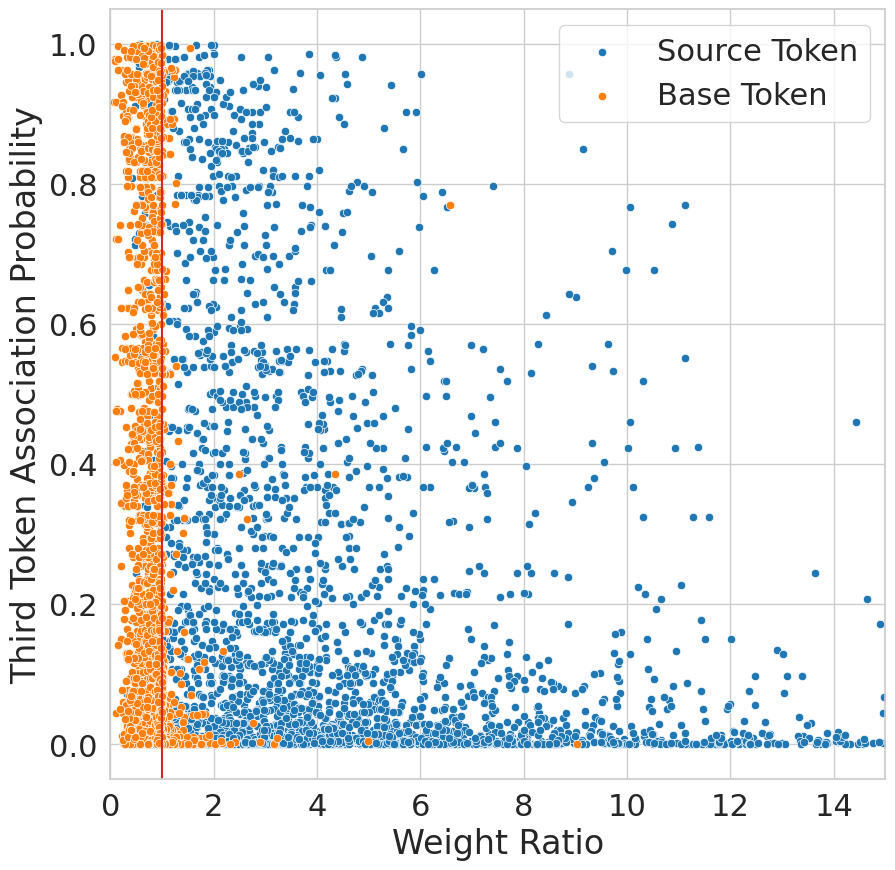

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(style="whitegrid", font_scale=2)
pallet = sns.color_palette("tab10")
source_color = pallet[0]
base_color = pallet[1]
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=df[df["Token Type"] == "Source"], x="Weight Ratio", y="Probability", ax=ax, color=source_color, label="Source Token")
sns.scatterplot(data=df[df["Token Type"] == "Base"], x="Weight Ratio", y="Probability", ax=ax, color=base_color, label="Base Token")
ax.set_xlabel("Weight Ratio")
ax.set_ylabel("Third Token Association Probability")
ax.set_xlim(0, 15)

# Draw a vertical line at x=1
plt.axvline(x=1, color=pallet[3], linestyle="-")

fig.savefig("city_weight_ratio_vs_probability.pdf")